# 3. Lab - Pipeline Ingeniería de características
### Juan del Carmen -- 23000827
### Marco Tebalan -- 23000825

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer, BoxCoxTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

In [169]:
def getColumnTypes (dataset):
    continuas = []
    categoricas = []
    discretas = []

    for col in dataset.columns:
        if dataset[col].dtype == 'int64' or dataset[col].dtype == 'float64':
            if dataset[col].nunique() > 30: # si la cantidad distintivos es mayor a 30, se asume que es una variable continua
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)

    return continuas, discretas, categoricas


def plotDistBoxQQ(dataset, col):
    ''' 
    Muestra graficas de distribucion, boxplot y QQ-Plot para deterctar outliers.
    dataset: pandas df
    col: pandas df column
    '''
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(dataset[col], bins=30)
    plt.title('Histograma y Densidad')

    plt.subplot(1,3,2)
    sns.boxplot(y=dataset[col])
    plt.title('Boxplot')

    import scipy.stats as stats
    plt.subplot(1,3,3)
    stats.probplot(dataset[col], dist='norm', plot=plt)
    plt.title("Q-Q Plot")


def VariableTransformer(dataset, cols):
    '''
    Transforma las variables cols del pandas df dataset para maximizar la normalidad.
    Consideaciones:
        - El algoritmo no garantiza normalidad en todos los casos, solo la aproxima.
        - Solo se aplican 4 transformaciones ditintas: Inversa, cuadratica, boxcox y YeoJhonson
        - Solo aplica una transformacion por variable
    Output: 
        - el dataset transfromado
        - resumen de las transfromaciones realizadas
    '''  
    transformation_summary = pd.DataFrame(columns=['Variable', 'Normalidad', 'Transformada', 'Método'])

    for col in cols:
        shapiro_test = stats.shapiro(dataset[col]).pvalue
        if shapiro_test <= 0.05: # si p es menor a alpha, se rechaza Ho (Ho = la data es normal)
            tag = False
            p_values = [] # Almacenamos los valores p para cada transformación
            transformations = [] # Almacenamos las columnas transformadas
            methods = [ 'Cuadratica','Inversa', 'Boxcox', 'YeoJohnson']
            


            # Método 2 - cuadratica
            transformed = dataset[col]**2
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)


            if (dataset[col] == 0).sum() < 1:
                # Método 1 - inversa
                transformed = 1 / dataset[col]
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

                # Método 3 - boxcox
                # transformed, _ = stats.boxcox(dataset[col] + 1e-6) # Evitamos valores de 0
                # _, p = stats.shapiro(transformed)
                # p_values.append(p)
                # transformations.append(transformed)

                # Método 4 - yeojohnson
                transformed, _ = stats.yeojohnson(dataset[col] + 1e-6) # Evitamos valores de 0
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

            # Escogemos la transformación con el mayor valor p
            best_transformation_data = transformations[np.argmax(p_values)]
            best_transformation_name = methods[np.argmax(p_values)]
            dataset[col] = best_transformation_data
            

            # Hacemos prueba de normalidad nuevamente
            shapiro_test = stats.shapiro(dataset[col]).pvalue
            if stats.shapiro(dataset[col]).pvalue <= 0.05:
                tag = False
            else:
                tag = True
            
            # Armamos fila con data actualizada
            new_row = pd.Series([col, tag, True, best_transformation_name], index=transformation_summary.columns)

        else:
            tag = True
            new_row = pd.Series([col, tag, False, np.NaN], index=transformation_summary.columns)
        
        transformation_summary = transformation_summary.append(new_row, ignore_index=True)
    return dataset, transformation_summary

In [170]:
df = pd.read_csv('train.csv', index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14447 entries, 9744 to 11554
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14447 non-null  float64
 1   latitude            14447 non-null  float64
 2   housing_median_age  14447 non-null  int64  
 3   total_rooms         14447 non-null  int64  
 4   total_bedrooms      14310 non-null  float64
 5   population          14447 non-null  int64  
 6   households          14447 non-null  int64  
 7   median_income       14447 non-null  float64
 8   median_house_value  14447 non-null  float64
 9   ocean_proximity     14447 non-null  object 
dtypes: float64(5), int64(4), object(1)
memory usage: 1.2+ MB


In [171]:
continuas, discretas, categoricas = getColumnTypes(df)
continuas

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [172]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.000000,14447.000000,14447.000000,14447.000000,14310.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,-119.580422,35.642011,28.845435,2635.287534,537.778756,1425.171454,500.116772,3.863949,206873.687824
std,2.003511,2.135526,12.585221,2215.285809,424.012399,1123.733449,386.181946,1.892919,115263.889710
min,-124.300000,32.540000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000
25%,-121.805000,33.930000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000
50%,-118.500000,34.260000,29.000000,2121.000000,433.000000,1163.000000,408.000000,3.535000,179700.000000
75%,-118.020000,37.720000,37.000000,3137.500000,647.000000,1722.000000,604.500000,4.722850,264600.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


## 1. Determinacion de nulos y 2. Proporcion de faltantes

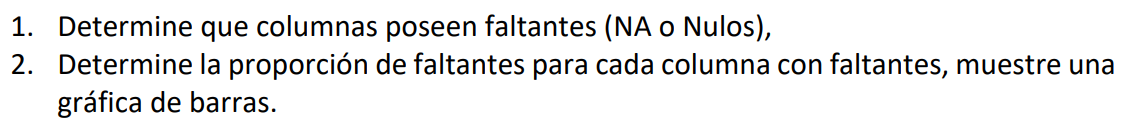

In [173]:
nan_vars =  df.isnull().mean()
nan_vars = nan_vars[lambda x: x>0]
nan_vars

total_bedrooms    0.009483
dtype: float64

<Axes: >

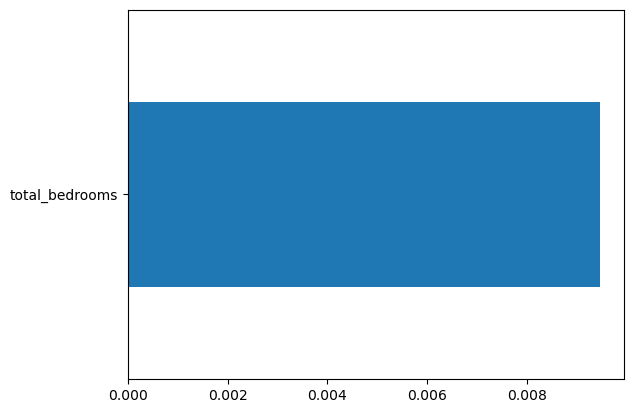

In [174]:
nan_proporcion.plot.barh()

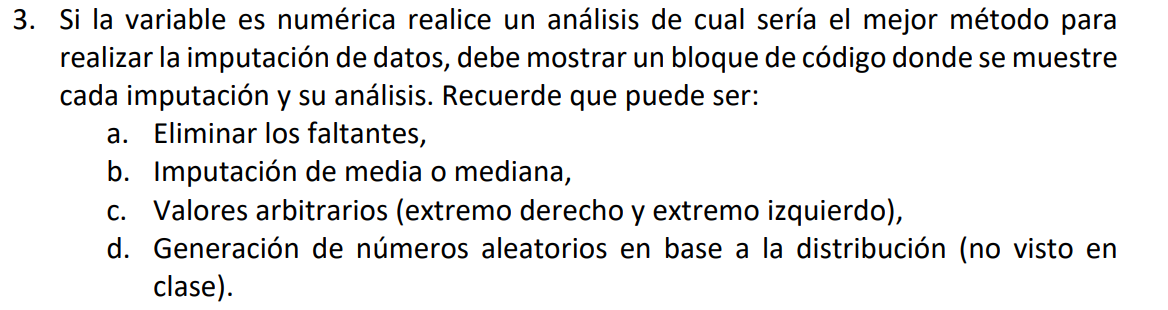

Debido a que la proporción es menor al 1%, se decició imputar media debido a que no generó ningun efecto en la distribución. Solo existe 1 variable con valores NaN y es numérica, por lo que se ingora el inciso 4

In [175]:
# a. eliminar datos faltantes

# proporcion de df sin datos faltantes
len(df.dropna()) / len(df)

0.9905170623658891

C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\3984443373.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


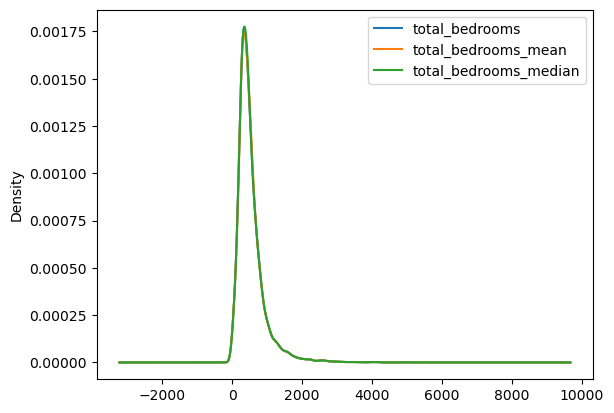

In [176]:
# b. media o mediana

t = pd.DataFrame(df[nan_vars.index[0]])
statss = t.agg(['median', 'mean'])
t['total_bedrooms_mean'] = t['total_bedrooms'].fillna(statss.loc['mean'].values[0])
t['total_bedrooms_median'] = t['total_bedrooms'].fillna(statss.loc['median'].values[0])

fig = plt.figure()
ax = fig.subplots()
t['total_bedrooms'].plot.density(label='total_bedrooms')
t['total_bedrooms_mean'].plot.density(label='total_bedrooms_mean')
t['total_bedrooms_median'].plot.density( label='total_bedrooms_median')
ax.legend()
fig.show()

In [177]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(statss.loc['mean'].values[0])


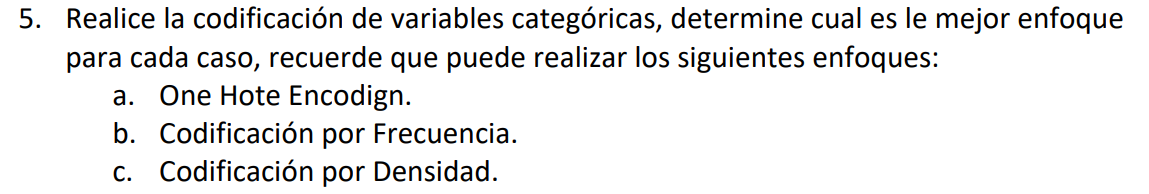

In [178]:
# Se decide utilzar codificacion por frecuencia
for cat in categoricas:
    temp_freqs = df[cat].value_counts(normalize=True).to_dict()
    df[f'{cat}_code'] = df[cat].map(temp_freqs)


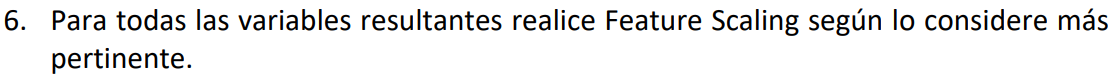

Como los datos de longitud tienen valores negativos, se considera utilizar MinMaxScaler para normalizar las variables

longitude
latitude


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)
C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


housing_median_age
total_rooms


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)
C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


total_bedrooms


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


population


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


households


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


median_income
median_house_value


C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)
C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\2552294885.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[col], bins=30)


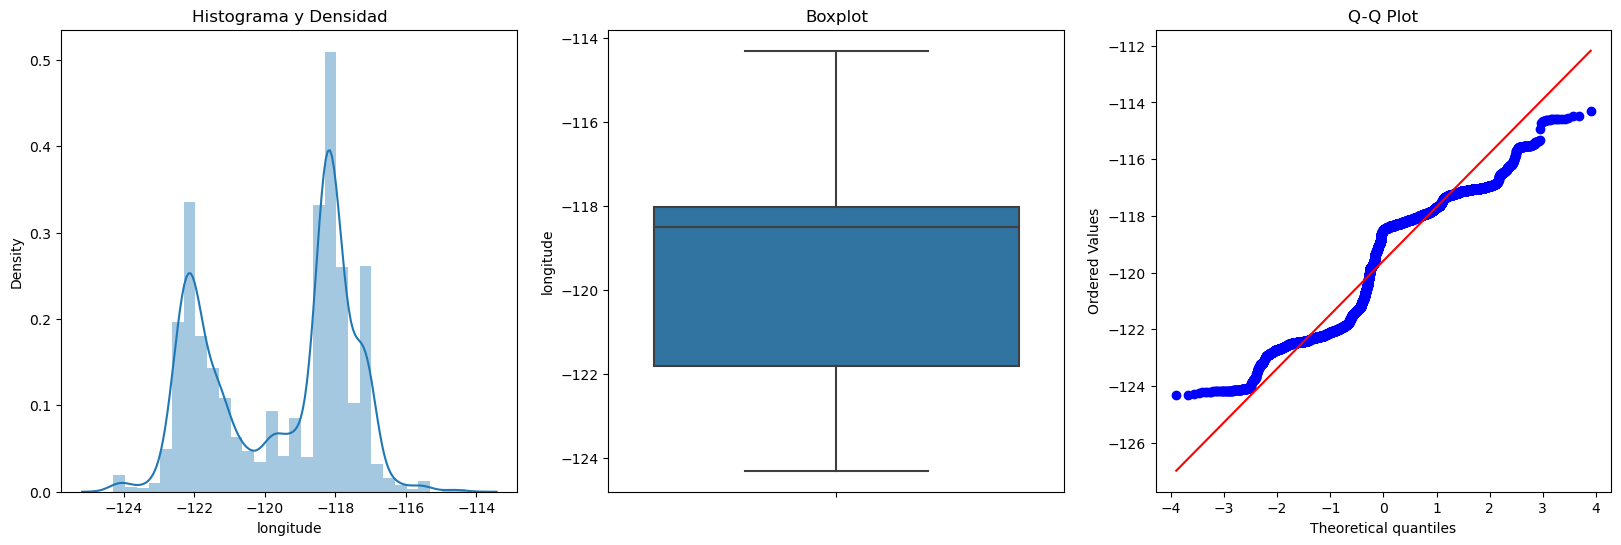

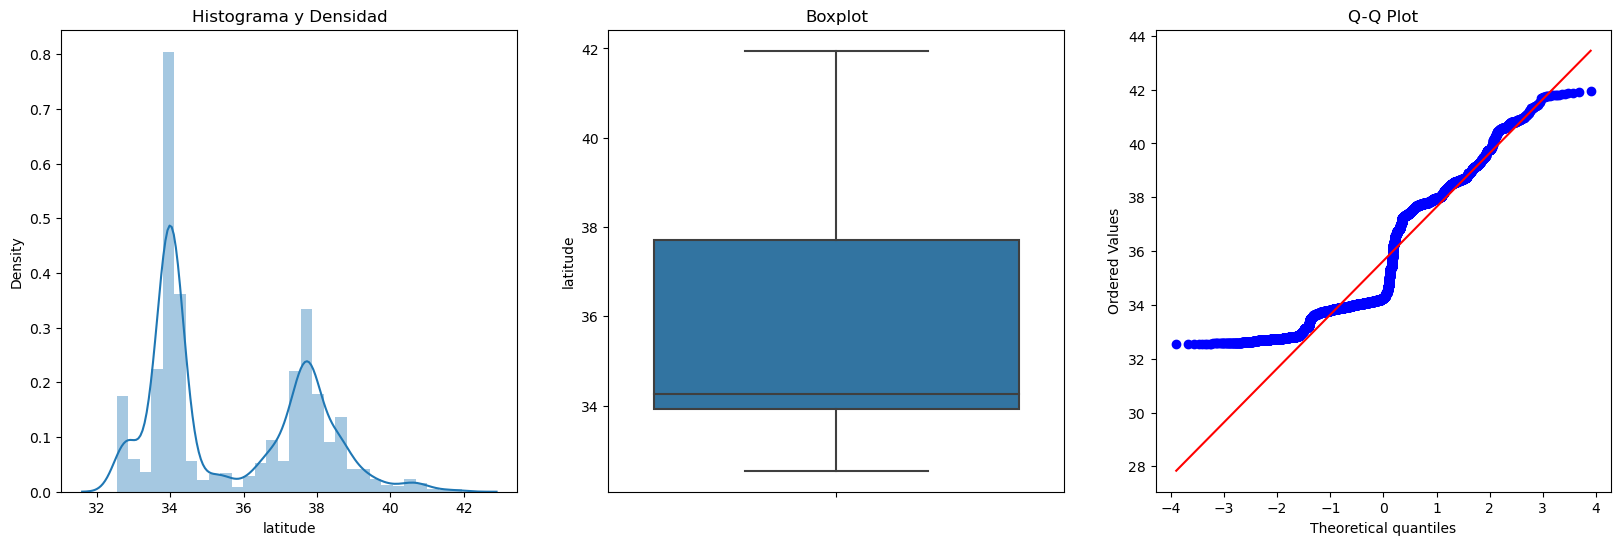

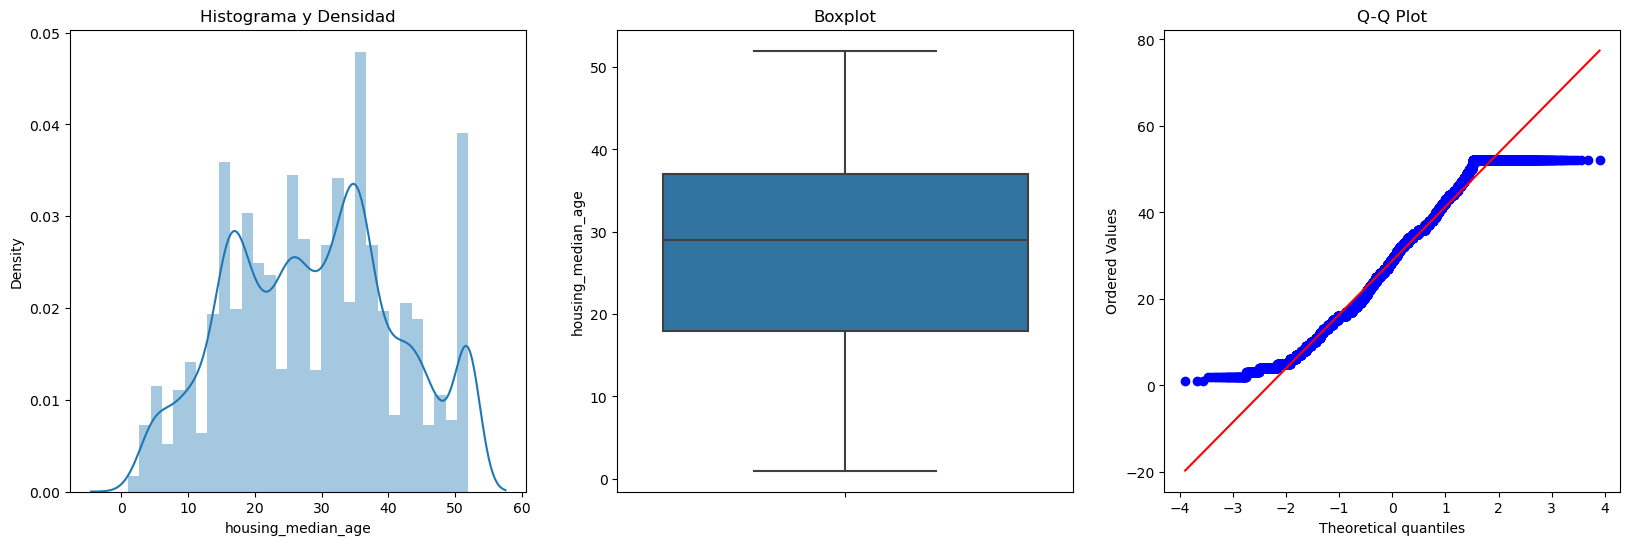

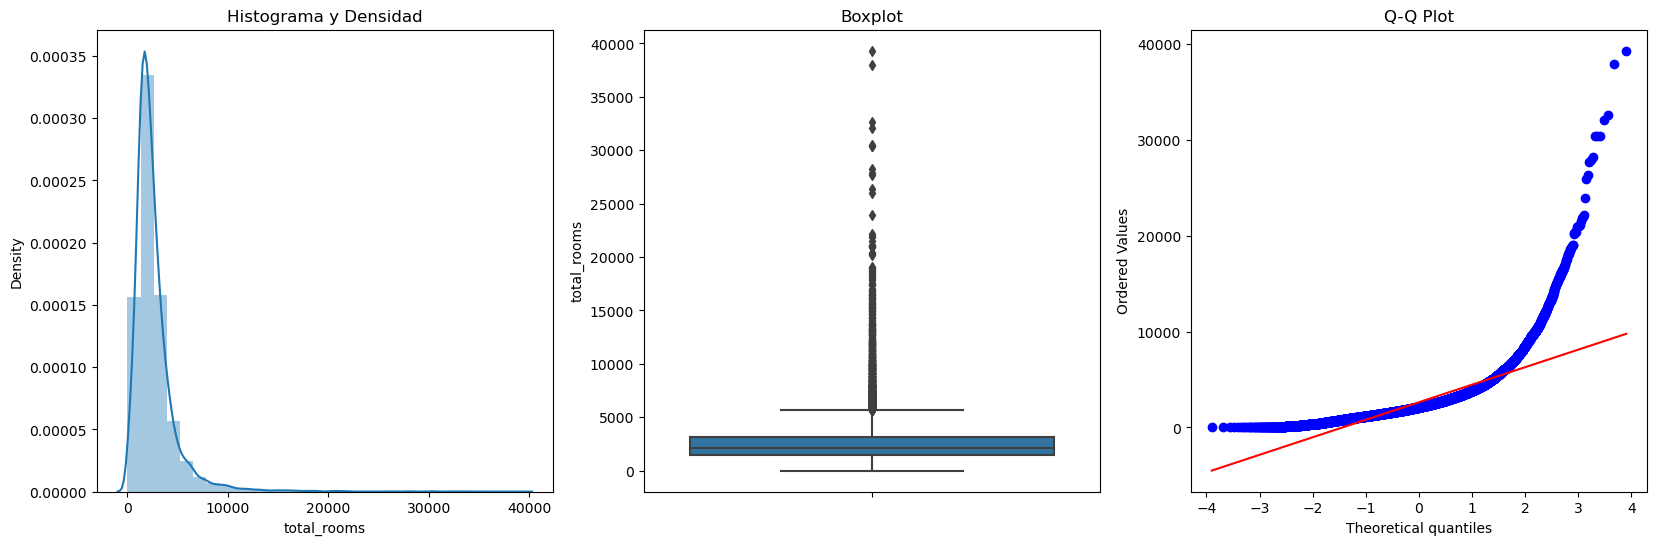

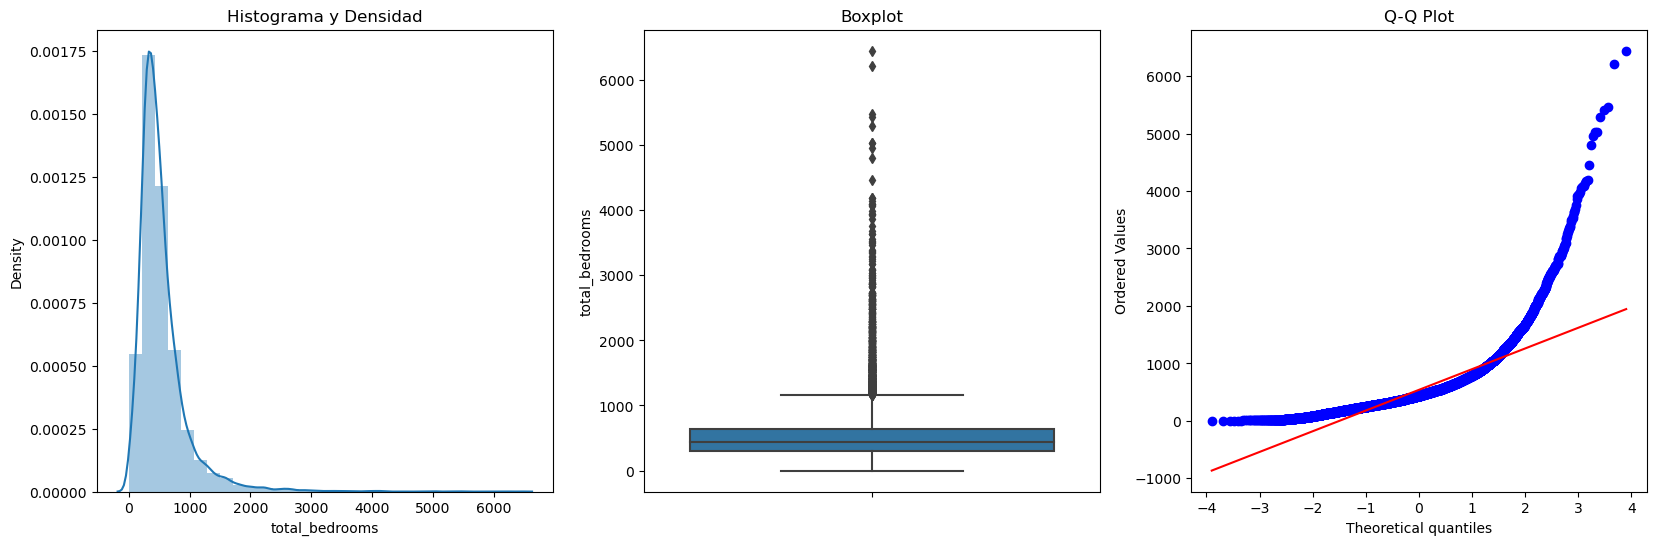

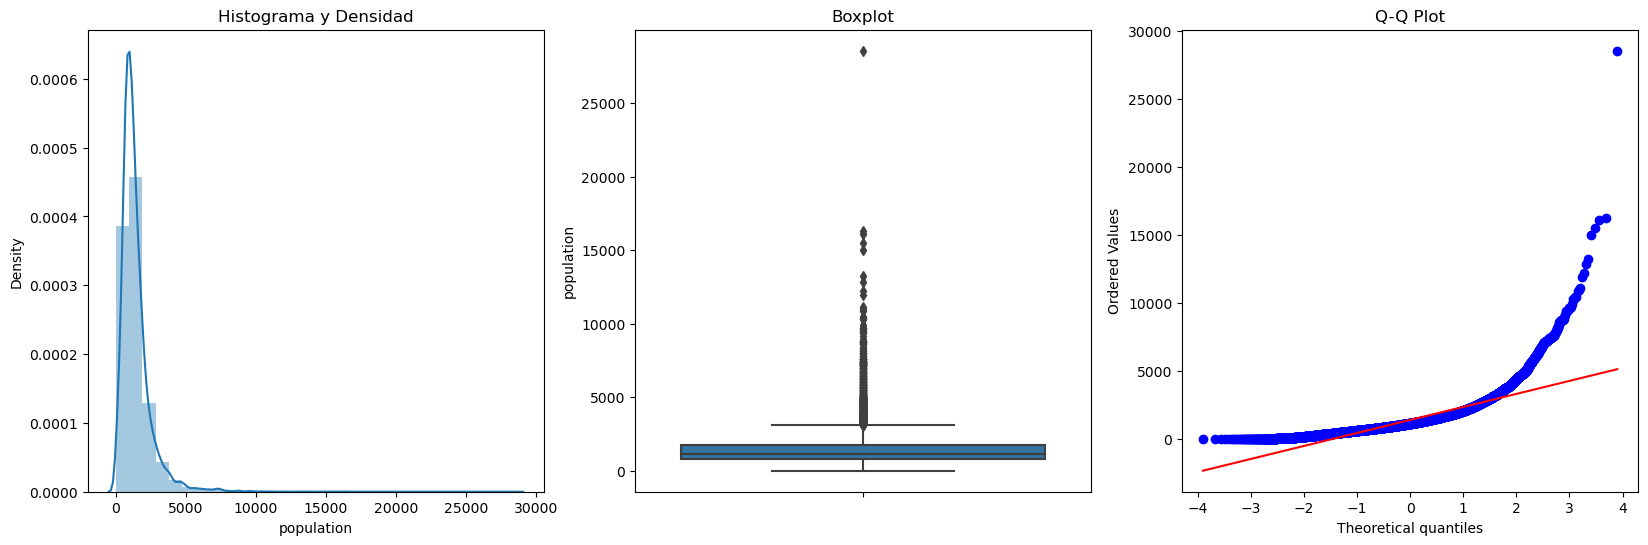

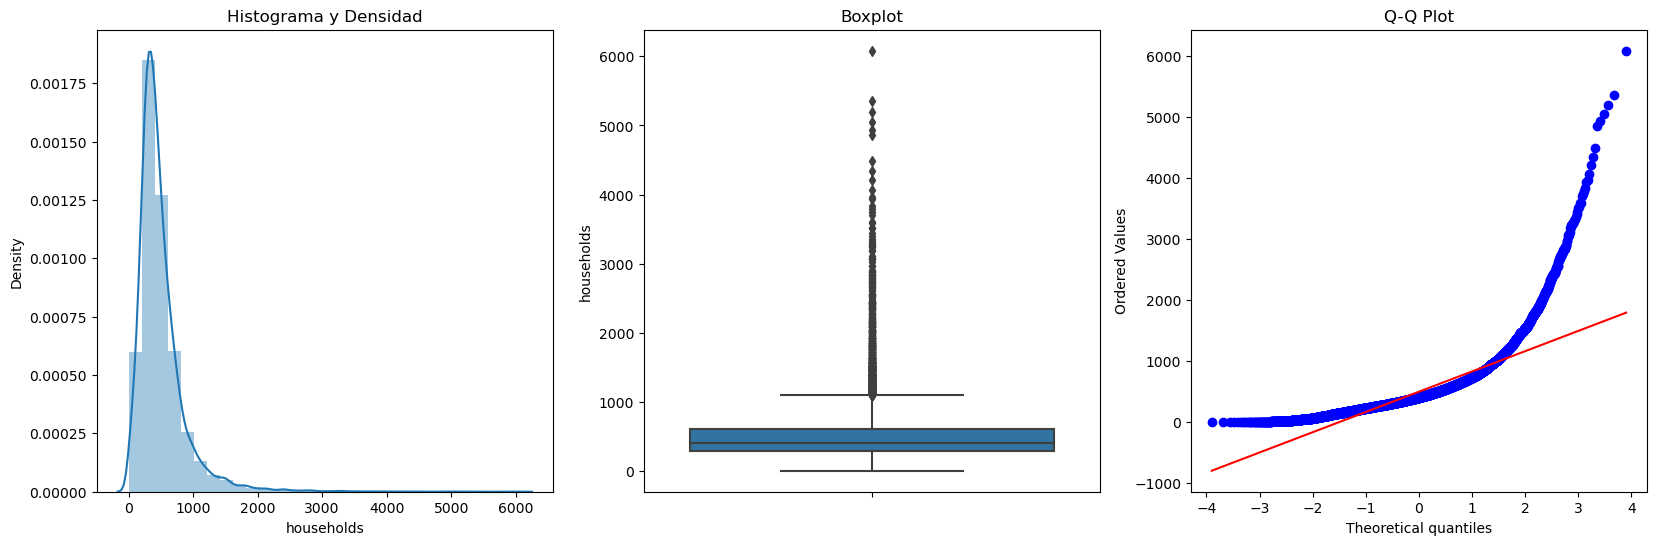

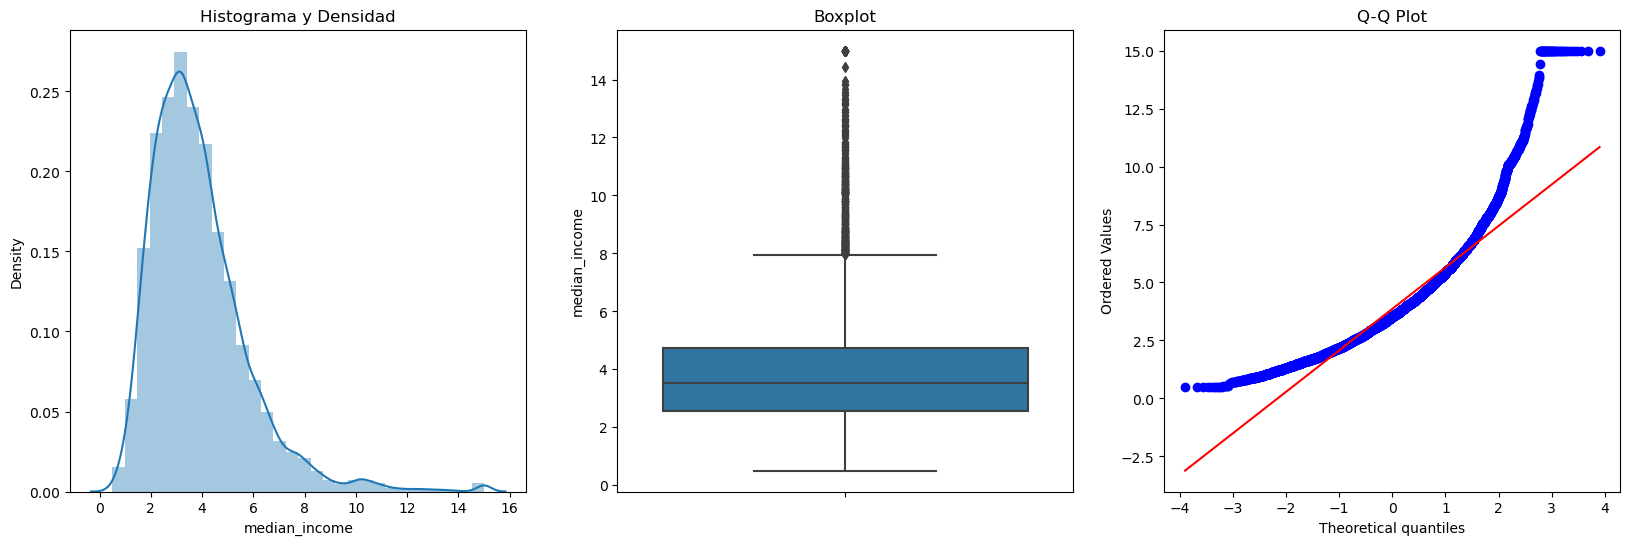

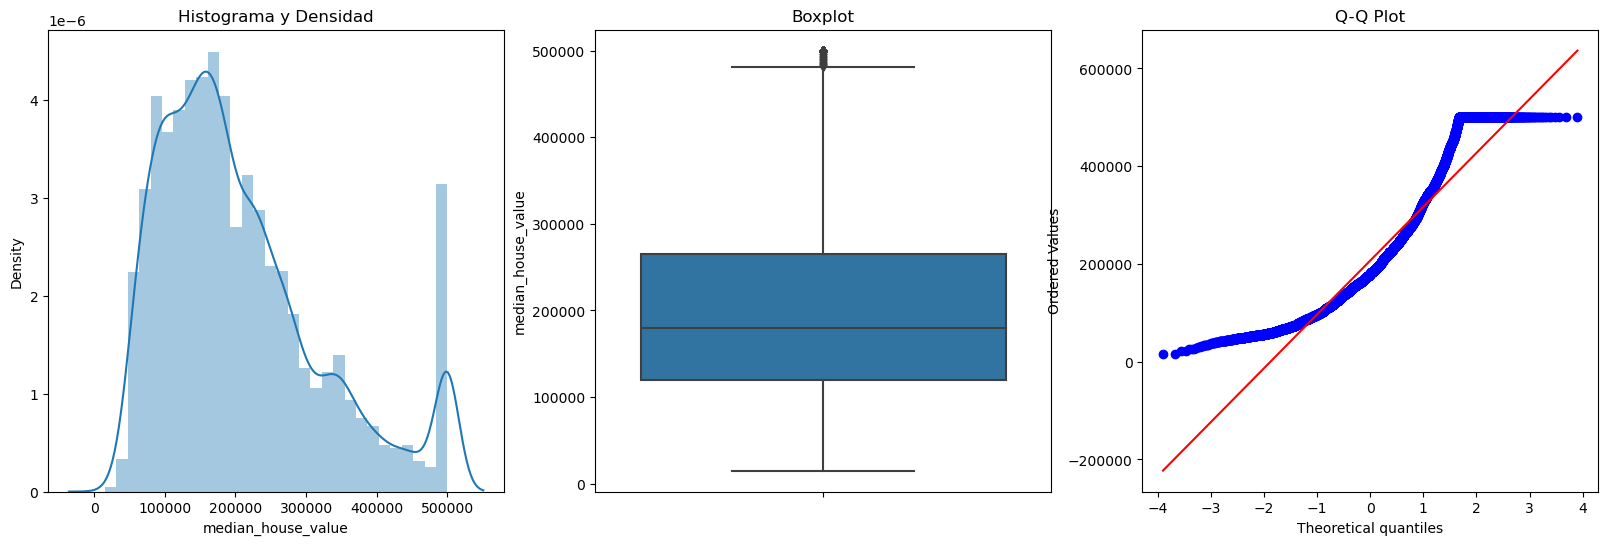

In [179]:
for col in continuas:
    print(col)
    plotDistBoxQQ(df, col)

In [180]:
pd.DataFrame(df.total_bedrooms).isna().sum()

total_bedrooms    0
dtype: int64

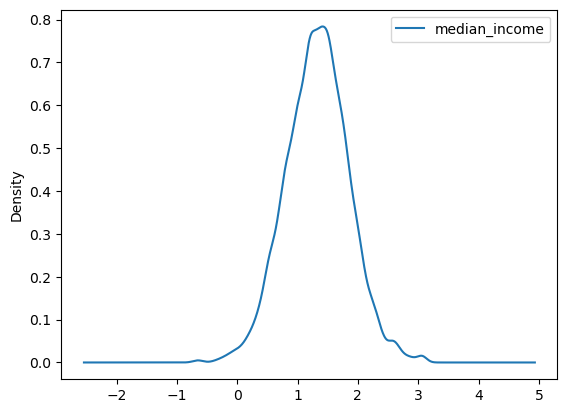

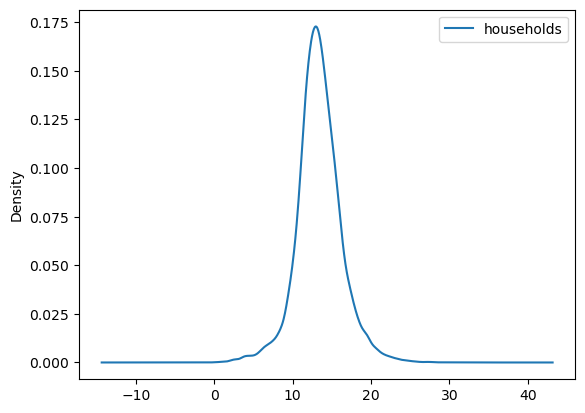

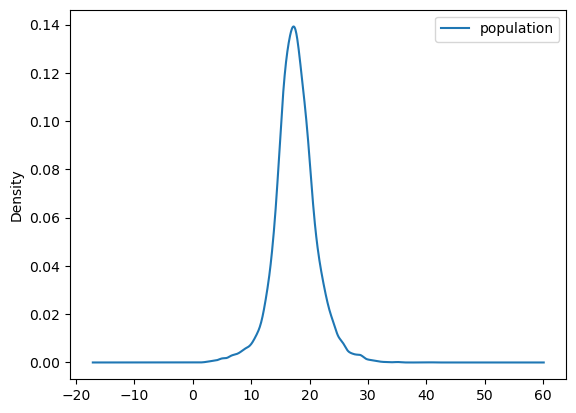

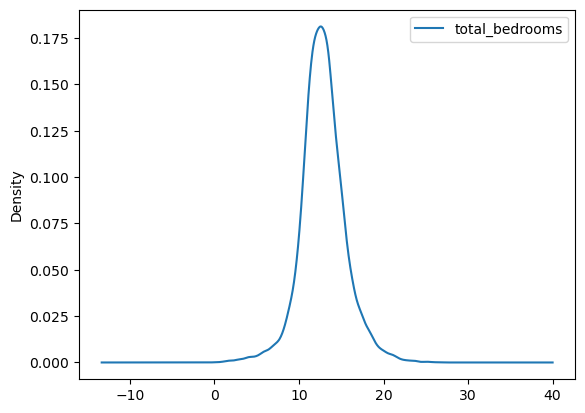

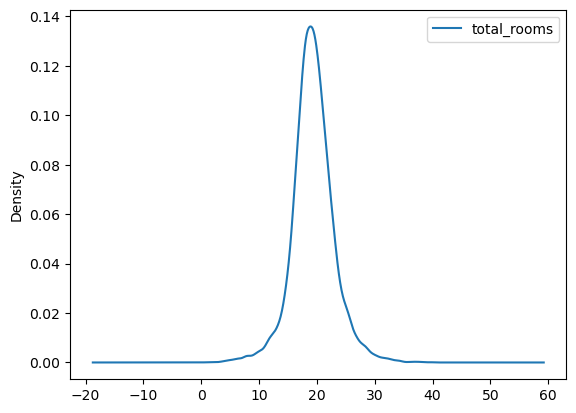

In [181]:
pt = BoxCoxTransformer()
for i in NUMERICAL_BOXCOX_VARS:

    pt.fit(pd.DataFrame(df[i]))
    pt.transform(pd.DataFrame(df[i])).plot.density()




# Construccion del Pipline

In [183]:
# variables categoricas
CATEGORICAL_VARS = categoricas

# variables numericas con vacio
NUMERICAL_VARS_WITH_NA = ['total_rooms']

NUMERICAL_BOXCOX_VARS = [
'median_income',
'households',
'population',
'total_bedrooms',
'total_rooms'
]

In [184]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code
id,,,,,,,,,,,
9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN,0.441891
13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND,0.316813
18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN,0.441891
16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY,0.112065
8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN,0.441891
...,...,...,...,...,...,...,...,...,...,...,...
557,-122.25,37.77,43,4329,1110.0,2086,1053,2.9750,243400.0,NEAR BAY,0.112065
16090,-122.48,37.71,43,3850,1018.0,1497,829,3.5296,400000.0,NEAR OCEAN,0.129093
9083,-118.17,34.69,12,4881,803.0,2188,724,4.1667,171900.0,INLAND,0.316813


In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['median_house_value', 'ocean_proximity_code'], axis=1),
    df['median_house_value'],
    test_size=0.3,
    random_state=2023)


In [186]:
housePrice_pipeline_v1 = Pipeline([
    
    #=========== IMPUTACIONES ===============
    
    #1. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #2. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('frequency_encoder',
        CountFrequencyEncoder(encoding_method='frequency', variables=CATEGORICAL_VARS)
    ),
    
    #=============== TRANSFORMACIÓN DE VARIABLES CONTINUAS ============
    ('boxcox_transformer',
        BoxCoxTransformer(variables=NUMERICAL_BOXCOX_VARS)
    ),
    
    
     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    #=============== REGRESION ============
    ('modelo_regresion', 
         LinearRegression()
    )
])


housePrice_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['total_rooms'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_rooms'])),
                ('frequency_encoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['ocean_proximity'])),
                ('boxcox_transformer',
                 BoxCoxTransformer(variables=['median_income', 'households',
                                              'population', 'total_bedrooms',
                                              'total_rooms'])),
                ('scaler', MinMaxScaler()),
                ('modelo_regresion', LinearRegression())])

In [187]:
preds = housePrice_pipeline_v1.predict(X_test)
rmseTest = np.sqrt(mean_squared_error(y_test, preds))
rmseTest



73520.85261195799

In [ ]:
rmseTest / (np.max((y_train)) - np.min((y_train)))

0.15397004951185023

In [195]:
transformaciones = Pipeline([
    
    #=========== IMPUTACIONES ===============
    
    #1. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #2. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('frequency_encoder',
        CountFrequencyEncoder(encoding_method='frequency', variables=CATEGORICAL_VARS)
    ),
    
    #=============== TRANSFORMACIÓN DE VARIABLES CONTINUAS ============
    ('boxcox_transformer',
        BoxCoxTransformer(variables=NUMERICAL_BOXCOX_VARS)
    ),
    
    
     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),

])


transformaciones.fit(df.drop('ocean_proximity_code', axis=1))


,0,1,2,3,4,5,6,7,8,9
0,0.265265,0.449522,0.274510,0.477936,0.450100,0.393712,0.430394,0.630409,0.438145,1.000000
1,0.803804,0.168969,0.705882,0.302123,0.307485,0.201432,0.237825,0.553746,0.104744,0.716860
2,0.223223,0.510096,0.666667,0.401142,0.365722,0.298908,0.350232,0.764616,1.000000,1.000000
3,0.191191,0.552604,1.000000,0.197183,0.172325,0.087654,0.173049,0.871585,0.432990,0.253369
4,0.592593,0.164718,0.529412,0.562123,0.660307,0.454109,0.638681,0.444458,0.531752,1.000000
...,...,...,...,...,...,...,...,...,...,...
14442,0.205205,0.555792,0.823529,0.573955,0.625106,0.475475,0.611904,0.486403,0.470928,0.253369
14443,0.182182,0.549416,0.823529,0.556417,0.610138,0.428561,0.570329,0.537226,0.793813,0.291915
14444,0.613614,0.228480,0.215686,0.592362,0.570523,0.482521,0.547805,0.587311,0.323506,0.716860
14445,0.286286,0.630181,0.078431,0.615897,0.635558,0.538330,0.624787,0.522576,0.193610,0.716860


In [198]:
df_transformada = df.drop('ocean_proximity_code', axis=1)
df_transformada.iloc[:, :] = transformaciones.transform(df.drop('ocean_proximity_code', axis=1))

df_transformada.to_csv('data_tranformada.csv')

C:\Users\juanj\AppData\Local\Temp\ipykernel_36404\132366968.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_transformada.iloc[:, :] = transformaciones.transform(df.drop('ocean_proximity_code', axis=1))


###